<a href="https://colab.research.google.com/github/kartik727/ml-projects/blob/master/basic-gan/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model, layers
import matplotlib.animation as animation
import numpy as np
import imageio
from IPython import display
from IPython.display import Image
from sklearn.decomposition import PCA
import logging
import json
import time
import os
import re

In [2]:
#@title Setting up training config

logging.basicConfig(level=logging.INFO)

config = {}
batch_size = 32 #@param {type:"integer"}
epochs = 200 #@param {type:"integer"}
relu_alpha = 0.1 #@param {type:"number"}

load_trained_model = True #@param {type:"boolean"}
train_model = False #@param {type:"boolean"}


In [3]:
os.system('mkdir out')
if load_trained_model:
    logging.info('Downloading trained model checkpoint')
    os.system('curl -o ckpt-17.data-00000-of-00001 https://media.githubusercontent.com/media/kartik727/ml-projects/master/basic-gan/ckpt-17.data-00000-of-00001')
    os.system('curl -o ckpt-17.index https://raw.githubusercontent.com/kartik727/ml-projects/master/basic-gan/ckpt-17.index')
    trained_model_loc = '/content/ckpt-17'
else:
    logging.info('Downloading trained model skipped')

INFO:root:Downloading trained model checkpoint


# Loading training data

In [4]:
def normalize_img(data):
    """Normalizes images: `uint8` -> `float32`."""
    norm = tf.cast(data['image'], tf.float32) / 255.
    return norm

# Construct a tf.data.Dataset
ds = tfds.load('RockPaperScissors', split='train', shuffle_files=True)
ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.cache()
ds = ds.shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/rock_paper_scissors/3.0.0


# Creating GAN model

Based on [Deep Convolutional Generative Adversarial Network | Tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan)

## 1. Generator

In [5]:
noise_dim = 512
noise_vector_shape = (1, 1, noise_dim)
image_shape = (300, 300, 3)

generator = Sequential([
    layers.InputLayer(input_shape=noise_vector_shape),
    layers.Conv2DTranspose(512, (5, 5), strides=5, padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.BatchNormalization(),
    layers.Conv2D(512, (5, 5), padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.Conv2DTranspose(128, (5, 5), strides=5, padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.BatchNormalization(),
    layers.Conv2D(128, (5, 5), padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.Conv2DTranspose(32, (3, 3), strides=3, padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.Conv2DTranspose(16, (3, 3), strides=2, padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.BatchNormalization(),
    layers.Conv2D(16, (3, 3), padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.Conv2DTranspose(8, (3, 3), strides=2, padding="same"),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.Conv2D(8, (3, 3), padding="same"),
    layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 5, 5, 512)        6554112   
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 5, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         6554112   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5, 5, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 25, 25, 128)      1

## 2. Discriminator

In [6]:
discriminator = Sequential([
    layers.InputLayer(input_shape=image_shape, batch_size=None),

    layers.Conv2D(8, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(16, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(128, (5, 5), padding='same'),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.MaxPooling2D((5, 5), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(512, (5, 5), padding='same'),
    layers.LeakyReLU(alpha=relu_alpha),
    layers.MaxPooling2D((5, 5), padding='same'),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 300, 300, 8)       224       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 300, 300, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 8)      0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 16)      1168      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                  

# Training

## Defining loss and optimizer

In [7]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
num_examples_to_generate = 16

In [9]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
if load_trained_model:
    checkpoint.restore(trained_model_loc)
    logging.info('Trained model loaded')
else:
    logging.info('Loading trained model skipped')

INFO:root:Trained model loaded


## Defining training step

In [10]:
@tf.function
def train_gen():
    noise = tf.random.normal([batch_size, *noise_vector_shape])

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=False)
        gen_loss = generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        return fake_output, gen_loss

@tf.function
def train_disc(images):
    noise = tf.random.normal([batch_size, *noise_vector_shape])

    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=False)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        return real_output, fake_output, disc_loss

In [11]:
def train(dataset, epochs):

    history = {
        'gen_train' : {
            'loss' : [],
            'fake_output' : []
        },
        'disc_train' : {
            'loss' : [],
            'real_output' : [],
            'fake_output' : []
        }
    }

    for epoch in range(epochs):
        start = time.time()
        num_steps_per_epoch = len(dataset)

        gen_train_fake_output = []
        disc_train_real_output = []
        disc_train_fake_output = []

        # Training generator
        for image_batch in range(num_steps_per_epoch):
            fake_output, gen_loss = train_gen()
            gen_train_fake_output.append(fake_output)

        # Training discriminator
        for image_batch in dataset.take(num_steps_per_epoch-1):
            real_output, fake_output, disc_loss = train_disc(image_batch)
            disc_train_real_output.append(real_output)
            disc_train_fake_output.append(fake_output)

        history['gen_train']['loss'].append(gen_loss)
        history['gen_train']['fake_output'].append(tf.convert_to_tensor(gen_train_fake_output))

        history['disc_train']['loss'].append(disc_loss)
        history['disc_train']['real_output'].append(tf.convert_to_tensor(disc_train_real_output))
        history['disc_train']['fake_output'].append(tf.convert_to_tensor(disc_train_fake_output))

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 num_examples_to_generate,
                                 noise_vector_shape,
                                 save=True)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             num_examples_to_generate,
                             noise_vector_shape,
                             save=True)
    return history

In [12]:
def generate_and_save_images(model, epoch, num_examples_to_generate, noise_vector_shape, save=False):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    seed = tf.random.normal([num_examples_to_generate, *noise_vector_shape])
    predictions = model(seed, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    if save:
        plt.savefig('/content/out/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training the model

In [13]:
if train_model:
    history = train(ds, epochs)

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(history['disc_train']['loss'], label='Discriminator loss')
    ax.plot(history['gen_train']['loss'], label='Generator loss')
    ax.legend()
    fig.show()
else:
    logging.info('Not training further')

INFO:root:Not training further


## Visualizing results

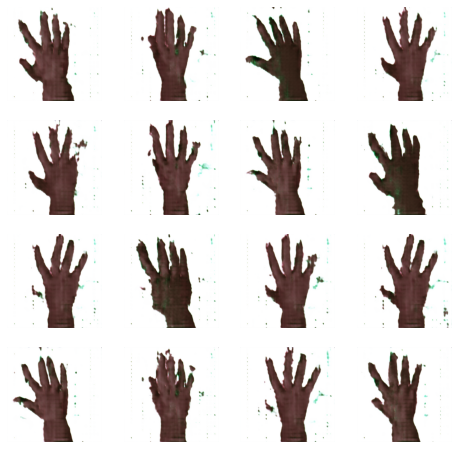

In [14]:
generate_and_save_images(generator,
                         epochs,
                         num_examples_to_generate,
                         noise_vector_shape,
                         save=False)